# Определение стоимости автомобилей

## Описание проекта


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Цель проекта

Построить модель, чтобы определить стоимость автомобиля.

## Описание данных

Данные содержат Датафрейм с информацией о компании.

## План работы

1. Подготовка данных
2. Обучение моделей
3. Анализ моделей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import time
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

In [2]:
#анализируем набор данных
filepath = r"C:\Users\erofe\Downloads\autos.csv"
df = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df.duplicated().sum())
#выводим первые 10 строк таблицы
print(df.head(10))
#выводим информацию о таблице
print(df.info())

4
           DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480          NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300        coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800          suv              2004    auto    163   
3  2016-03-17 16:54:04   1500        small              2001  manual     75   
4  2016-03-31 17:25:20   3600        small              2008  manual     69   
5  2016-04-04 17:36:23    650        sedan              1995  manual    102   
6  2016-04-01 20:48:51   2200  convertible              2004  manual    109   
7  2016-03-21 18:54:38      0        sedan              1980  manual     50   
8  2016-04-04 23:42:13  14500          bus              2014  manual    125   
9  2016-03-17 10:53:50    999        small              1998  manual    101   

     Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0     golf     150000                  0    petrol  v

In [3]:
#Проверка на неявные дубликаты
print(df['VehicleType'].unique())
print(df['Gearbox'].unique())
print(df['Model'].unique())
print(df['FuelType'].unique())
print(df['Brand'].unique())
print(df['Repaired'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

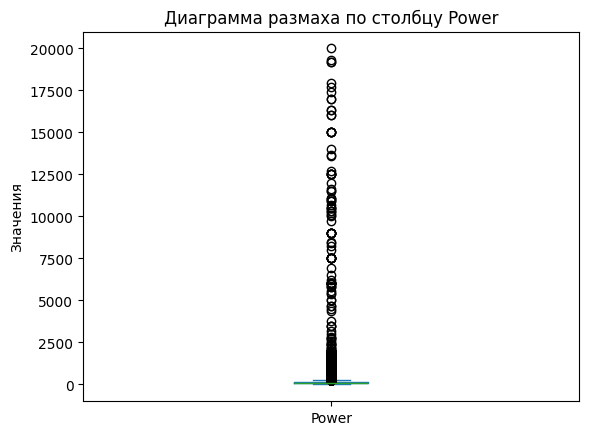

In [4]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df['Power'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу Power', ylabel = 'Значения')
plt.show()

В данных присутствует большое количество в разных столбцах(VehicleType, Gearbox, Model, FuelType, FuelType, Repaired). Есть 4 полных дубликата(будет удалено). Неправильные типы данных в столбцах с датой. Неявных дубликатов не найдено. Так же есть данные с нулевым значением в цене, чего быть не может(эти данные мы удалим, так как данные без целевого признака нам не интересны). Будут удалены выбросы в столбце power.

In [5]:
#Уничтожаем дубликаты
df = df.drop_duplicates().reset_index(drop = True)

In [6]:
#Меняем тип данных на дату
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

In [7]:
#Удаляем нулевые значения
df = df.query('Price > 0')
df = df.reset_index(drop = True)

In [8]:
#строим функцию для удаления выбросов
def remove_outliers(data, column_name, threshold=1.5):
    
    # Вычисляем квартили для столбца
    Q1 = data[column_name].quantile(0.01)
    Q3 = data[column_name].quantile(0.99)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Вычисляем границы для определения выбросов
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Удаляем выбросы
    data_cleaned = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]
    
    return data_cleaned

In [9]:
#Удаляем выбросы и нулевые значения
df = remove_outliers(df, 'Power')
df = df.query('Power > 35') #Поставим такое количество минимальных лошадиных сил, так как машин меньше 35 лошадиных сил сложно найти

Во всех данных, где значений больше 2, замениним неизвестные значения на Unknown. В данных, где 2 значения, меняем на самое популярное.

In [10]:
df.fillna({'VehicleType':'unknown', 'Repaired':'no', 'Model':'unknown','Gearbox':'manual', 'FuelType':'unknown'}, inplace=True)

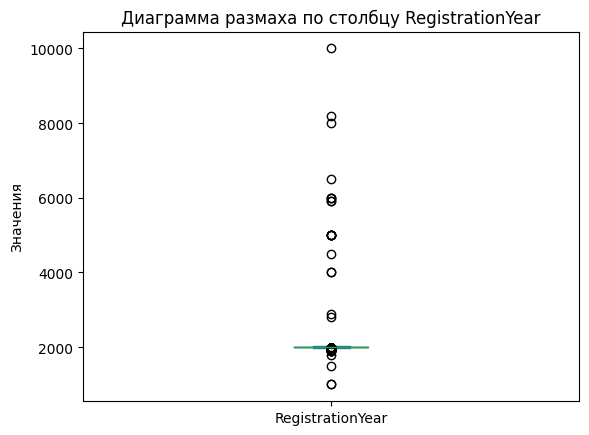

In [11]:
df['RegistrationYear'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу RegistrationYear', ylabel = 'Значения')
plt.show()

In [12]:
#Удаляем выбросы
df = df.query('RegistrationYear < 2023')
df = df.query('RegistrationYear > 1970') #Поставим такое количество минимального года, так как машины раньше 1970 сложно найти.

In [13]:
df['DateCrawled'].describe()

count                           305067
mean     2016-03-21 13:18:21.598016512
min                2016-03-05 14:06:22
25%         2016-03-13 11:48:43.500000
50%                2016-03-21 17:58:19
75%         2016-03-29 14:49:32.500000
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [14]:
#Удаляем константный признак
df = df.drop(['DateCrawled'], axis=1)

In [15]:
df = df.reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305067 entries, 0 to 305066
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              305067 non-null  int64         
 1   VehicleType        305067 non-null  object        
 2   RegistrationYear   305067 non-null  int64         
 3   Gearbox            305067 non-null  object        
 4   Power              305067 non-null  int64         
 5   Model              305067 non-null  object        
 6   Kilometer          305067 non-null  int64         
 7   RegistrationMonth  305067 non-null  int64         
 8   FuelType           305067 non-null  object        
 9   Brand              305067 non-null  object        
 10  Repaired           305067 non-null  object        
 11  DateCreated        305067 non-null  datetime64[ns]
 12  NumberOfPictures   305067 non-null  int64         
 13  PostalCode         305067 non-null  int64   

Вывод: В данной части работы были подготовлены и предобработаны данные. Были уничтожены полные дубликаты, нулевые значения(часть было удалено, часть заменены) и аномальные значения и удален константный признак.

In [16]:
#Удаляем ненужный нам признак
print(df['NumberOfPictures'].unique())
df = df.drop(['NumberOfPictures'], axis=1)
df = df.reset_index(drop = True)
df.info()

[0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305067 entries, 0 to 305066
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              305067 non-null  int64         
 1   VehicleType        305067 non-null  object        
 2   RegistrationYear   305067 non-null  int64         
 3   Gearbox            305067 non-null  object        
 4   Power              305067 non-null  int64         
 5   Model              305067 non-null  object        
 6   Kilometer          305067 non-null  int64         
 7   RegistrationMonth  305067 non-null  int64         
 8   FuelType           305067 non-null  object        
 9   Brand              305067 non-null  object        
 10  Repaired           305067 non-null  object        
 11  DateCreated        305067 non-null  datetime64[ns]
 12  PostalCode         305067 non-null  int64         
 13  LastSeen           305067 non-null  date

## Обучение моделей

In [17]:
# Разделяем данные на признаки и целевую переменную
X = df.drop(['Price'], axis=1)
y = df['Price']

# Разбиение данных на обучающую (60%), валидационную (20%) и тестовую (20%) выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Определение количественных и категориальных признаков
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание трансформатора для категориальных данных(OE)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Создание трансформатора для категориальных данных(OHE)
categorical_transformer1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Создание ColumnTransformer (OE)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создание ColumnTransformer (OHE)
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

# Определение моделей
models = {
    'LinearRegression': {'model': LinearRegression(), 'param_grid': {}},
    'DecisionTreeRegressor': {'model': DecisionTreeRegressor(random_state=42), 
                              'param_grid': {'regressor__max_depth': [5, 10, 15]}},
    'LGBMRegressor': {'model': LGBMRegressor(random_state=42), 
                      'param_grid': {'regressor__n_estimators': [50, 100, 200], 'regressor__max_depth': [5, 10, 15]}}
}

In [18]:
%%time
results = {}
# Модель Linear Regression
model_name = 'LinearRegression'
config = models[model_name]

pipeline = Pipeline([
    ('preprocessor', preprocessor1),
    ('regressor', config['model'])
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = pipeline.predict(X_val)
prediction_time = time.time() - start_time

rmse = mean_squared_error(y_val, y_pred, squared=False)

results[model_name] = {
    'best_model': pipeline,
    'RMSE': rmse,
    'training_time': training_time,
    'prediction_time': prediction_time
}

for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  RMSE на валидационной выборке - {result['RMSE']}")
    print(f"  Время обучения - {result['training_time']} сек.")
    print(f"  Время предсказания - {result['prediction_time']} сек.\n")

LinearRegression:
  RMSE на валидационной выборке - 2503.0058066371116
  Время обучения - 2.6848998069763184 сек.
  Время предсказания - 0.08528494834899902 сек.

CPU times: total: 1.98 s
Wall time: 2.77 s


In [19]:
%%time
results = {}
# Модель Decision Tree Regressor

model_name = 'DecisionTreeRegressor'
config = models[model_name]

pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', config['model'])
])

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(pipeline1, config['param_grid'], scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

start_time = time.time()
y_pred = grid_search.predict(X_val)
prediction_time1 = time.time() - start_time

start_time = time.time()
pipeline1.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = pipeline1.predict(X_val)
prediction_time = time.time() - start_time

rmse = mean_squared_error(y_val, y_pred, squared=False)

results[model_name] = {
    'best_model': pipeline1,
    'RMSE': rmse,
    'training_time': training_time,
    'prediction_time': prediction_time
}

for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Время обучения модели с лучшими параметрами - {grid_search.refit_time_} сек.")
    print(f"  Время предсказания модели с лучшими параметрами - {prediction_time1} сек.")
    print(f"  RMSE на валидационной выборке - {result['RMSE']}")
    print(f"  Время обучения - {result['training_time']} сек.")
    print(f"  Время предсказания - {result['prediction_time']} сек.\n")

DecisionTreeRegressor:
  Время обучения модели с лучшими параметрами - 0.8672754764556885 сек.
  Время предсказания модели с лучшими параметрами - 0.06860589981079102 сек.
  RMSE на валидационной выборке - 2149.3856909576225
  Время обучения - 1.2254929542541504 сек.
  Время предсказания - 0.09139847755432129 сек.

CPU times: total: 2.72 s
Wall time: 8.12 s


In [33]:
%%time
results = {}

# Модель LGBM Regressor
model_name = 'LGBMRegressor'
config = models[model_name]

pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', config['model'])
])

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(pipeline2, config['param_grid'], scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

start_time = time.time()
y_pred = grid_search.predict(X_val)
prediction_time1 = time.time() - start_time

start_time = time.time()
pipeline2.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = pipeline2.predict(X_val)
prediction_time = time.time() - start_time

rmse = mean_squared_error(y_val, y_pred, squared=False)

results[model_name] = {
    'best_model': pipeline2,
    'RMSE': rmse,
    'training_time': training_time,
    'prediction_time': prediction_time
}

for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Время обучения модели с лучшими параметрами - {grid_search.refit_time_} сек.")
    print(f"  Время предсказания модели с лучшими параметрами - {prediction_time1} сек.")
    print(f"  RMSE на валидационной выборке - {result['RMSE']}")
    print(f"  Время обучения - {result['training_time']} сек.")
    print(f"  Время предсказания - {result['prediction_time']} сек.\n")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 183040, number of used features: 11
[LightGBM] [Info] Start training from score 4801.442881
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

Вывод: Лучшей моделью по качеству оказался градиентный бустинг, далее идет дерево решений, ну а совсем плохая модель это линейная регрессия(rmse больше 2500). По времени обучения и предсказания модели быстрее всего линейная регрессия(и по скорости 1 итерации и по общему времени), а медленнее всего градиентный бустинг(скорость 1 итерации схожа с деревом классификаций, но общее время сильно дольше)

In [23]:
#Тестируем лучшую модель(дерево решений) на переобучение
y_pred = pipeline1.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"  RMSE на тестовой выборке - {rmse}")

  RMSE на тестовой выборке - 2165.69365902115


RMSE на тестовой выборке схоже, переобучения не произошло.

## Анализ моделей

Вывод: По точности, третья модель является очень привлекательной. Но я бы все равно выбрал 2(дерево решений)она работает лучше всего, если считать соотношение 3 факторов.

## Общий вывод

Были загружены данные, после чего проведена предварительная обработка. Осуществлено сравнение различных моделей при применении разнообразных наборов гиперпараметров. На основе метрики RMSE и времени обучения была определена наилучшая модель. По точности, третья модель является очень привлекательной. Но я бы все равно выбрал 2(дерево решений)она работает лучше всего, если считать соотношение 3 факторов.